In [2]:
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

In [3]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


In [8]:
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-large")
model = AutoModel.from_pretrained("thenlper/gte-large")

model.cuda()

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [4]:
data = []

with open('result-mixtral.jsonl') as f:
    for x in tqdm(f):
        try:
            data.append(json.loads(x))
        except:
            continue


1060116it [00:14, 74084.80it/s] 


In [5]:
len(data)

1060116

In [6]:
embeddings = []

with open('embedding-result-filtered.jsonl') as f:
    for x in tqdm(f):
        try:
            embeddings.append(np.array(json.loads(x)))
        except:
            continue

265595it [02:14, 1971.86it/s]


In [27]:
batch_size = 5

with torch.no_grad():

    for i in tqdm(range(len(embeddings), len(data), batch_size)):

        batch = [x['en'] for x in data[i:i+batch_size]]

        batch_dict = tokenizer(batch, max_length=1024, padding=True, truncation=True, return_tensors='pt').to('cuda')

        outputs = model(**batch_dict)

        embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

        # Write each batch of responses to the file
        with open('embedding-result-filtered.jsonl', 'a') as f:
            for i in range(len(embeddings)):
                json.dump(embeddings[i].detach().cpu().numpy().tolist(), f)
                f.write('\n')

 47%|████▋     | 46042/98664 [26:29<30:16, 28.97it/s]  

KeyboardInterrupt



In [12]:
embeddings_np = np.array(embeddings)
labels = [eval(x['output'])['label'] for x in data[:len(embeddings)]]

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

unique_labels = [x for x in np.unique(labels) if x == 'harassment' or x== 'hate' ]

colors = plt.cm.get_cmap('tab10', len(unique_labels))

/tmp/ipykernel_51/2477644054.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


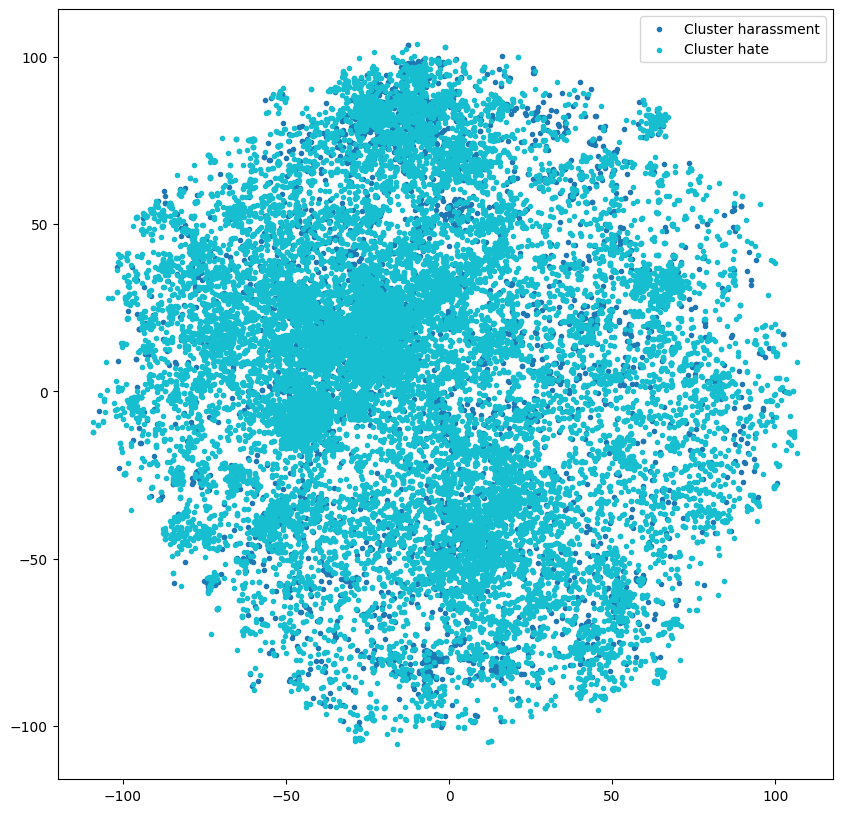

In [13]:
plt.figure(figsize=(10, 10))
for i, label in enumerate(unique_labels):
    indices = np.where(np.array(labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                marker='.', color=colors(i), label=f'Cluster {label}')

plt.legend()
plt.show()

In [14]:
embeddings_np = np.array(embeddings)
labels = [eval(x['output'])['label'] for x in data[:len(embeddings)]]

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

unique_labels = [x for x in np.unique(labels) if x != 'informative' and x!= 'safe for work' and x!= 'harassment'  and x!= 'hate']

colors = plt.cm.get_cmap('tab10', len(unique_labels))

/tmp/ipykernel_51/3114117098.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


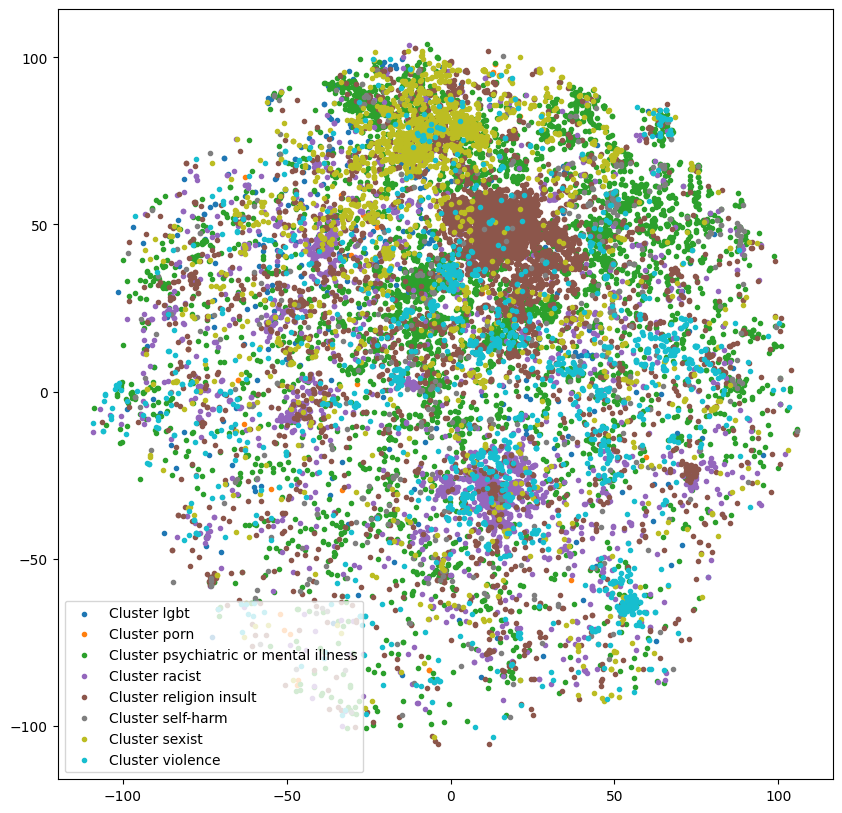

In [15]:
plt.figure(figsize=(10, 10))
for i, label in enumerate(unique_labels):
    indices = np.where(np.array(labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                marker='.', color=colors(i), label=f'Cluster {label}')

plt.legend()
plt.show()